# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random 

from ydata_profiling          import ProfileReport
from sklearn.preprocessing    import MinMaxScaler,RobustScaler
from sklearn.model_selection  import train_test_split, StratifiedKFold
from sklearn.ensemble         import RandomForestClassifier
from sklearn.linear_model     import LogisticRegression
from sklearn.metrics          import accuracy_score, precision_score,confusion_matrix,recall_score
from xgboost                  import XGBClassifier
from sklearn.neighbors        import KNeighborsClassifier

pd.set_option('display.max_columns',None)
pd.set_option('display.precision', 3)

%matplotlib inline

# Helper Functions

In [2]:
def ml_metrics( model_name, y_true, yhat):
    accuracy = accuracy_score(y_true, yhat)
    precision = precision_score(y_true, yhat)
    recall = recall_score(y_true, yhat)

    return pd.DataFrame({'Model Name': model_name, 
                        'ACC': accuracy,
                        'PRECISION': precision,
                        'RECALL': recall}, index = [0])

In [3]:
def model_cross_validation(model_name, model, X, y):
    skf = StratifiedKFold(n_splits=5)
    acc = []
    prec = []
    rec = []
    for train_index, test_index in skf.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_fold, y_test_fold = y.iloc[train_index,:], y.iloc[test_index,:]

        model.fit(x_train_fold, y_train_fold.values.ravel())

        y_hat = model.predict(x_test_fold)

        acc.append(accuracy_score(y_test_fold, y_hat))
        prec.append(precision_score(y_test_fold, y_hat))
        rec.append(recall_score(y_test_fold, y_hat))


    result = {'Model Name': model_name, 
                'Mean ACC': round(100*np.mean(acc),2),
                'Std ACC': round(100*np.std(acc),2),
                'Mean PRECISION': round(100*np.mean(prec),2),
                'Std PRECISION': round(100*np.std(prec),2),
                'Mean RECALL': round(100*np.mean(rec),2),
                'Std RECALL': round(100*np.std(rec),2)}
    return pd.DataFrame(result, index = [0])

# Load Data

In [4]:
path = '../data/raw/'

In [5]:
df = pd.read_csv(path + 'cardio_train.csv',sep = ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
# gender => 1:female, 2:male

# Data Description

## Rename columns

In [7]:
df.rename(columns = {'ap_hi':'systolic','ap_lo':'diastolic','alco':'alcohol'}, inplace = True)

## Data dimension

In [8]:
print('Quantity of rows and columns: {}'.format(df.shape))

Quantity of rows and columns: (70000, 13)


## Data types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   systolic     70000 non-null  int64  
 6   diastolic    70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alcohol      70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## Check NA

In [10]:
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
systolic       0
diastolic      0
cholesterol    0
gluc           0
smoke          0
alcohol        0
active         0
cardio         0
dtype: int64

## Replace NA

In [11]:
# None

## Change dtypes

In [12]:
# None

## Descriptive Statistics

In [13]:
df1 = df.copy()

### Numerical Attributes

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [15]:
# central tendency
ct_mean = pd.DataFrame( num_attributes.apply( np.mean )).T
ct_median = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion

ct_std = pd.DataFrame( num_attributes.apply( np.std )).T
ct_min = pd.DataFrame( num_attributes.apply( np.min )).T
ct_max = pd.DataFrame( num_attributes.apply( np.max )).T
ct_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
ct_skew = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
ct_kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

In [16]:
num_analysis = pd.concat([ct_mean, ct_median, ct_std, ct_min, 
                          ct_max, ct_range, ct_skew, ct_kurtosis]).T.reset_index()
num_analysis.columns = ['attributes','mean','median','std','min','max','range','skew','kurtosis']
num_analysis

# kurtosis > 0 -> it is more "narrowed" the distribution
# skew > 0 -> the distribution tend to be more on the right side (values above the 'mean')

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,id,49972.420,50001.5,28851.096,0.0,99999.0,99999.0,-0.001,-1.198
1,age,19468.866,19703.0,2467.234,10798.0,23713.0,12915.0,-0.307,-0.823
2,gender,1.350,1.0,0.477,1.0,2.0,1.0,0.631,-1.602
3,height,164.359,165.0,8.210,55.0,250.0,195.0,-0.642,7.944
4,weight,74.206,72.0,14.396,10.0,200.0,190.0,1.012,2.587
5,systolic,128.817,120.0,154.010,-150.0,16020.0,16170.0,85.296,7580.075
6,diastolic,96.630,80.0,188.471,-70.0,11000.0,11070.0,32.114,1425.915
7,cholesterol,1.367,1.0,0.680,1.0,3.0,2.0,1.587,0.994
8,gluc,1.226,1.0,0.572,1.0,3.0,2.0,2.397,4.294
9,smoke,0.088,0.0,0.283,0.0,1.0,1.0,2.906,6.444


# Data Filtering

In [17]:
df2 = df1.copy()
df2.shape

(70000, 13)

In [18]:
for i in ['cholesterol', 'gluc', 'smoke', 'alcohol', 'active']:
    print(i,'\n',df2[i].value_counts(normalize = True)*100)

cholesterol 
 1    74.836
2    13.641
3    11.523
Name: cholesterol, dtype: float64
gluc 
 1    84.970
3     7.616
2     7.414
Name: gluc, dtype: float64
smoke 
 0    91.187
1     8.813
Name: smoke, dtype: float64
alcohol 
 0    94.623
1     5.377
Name: alcohol, dtype: float64
active 
 1    80.373
0    19.627
Name: active, dtype: float64


## incorrect weight

In [19]:
df2.loc[df2['gender'] == 1].sort_values(by='weight').head(10)

,id,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,cardio
60188,85931,21855,1,162,21.0,120,80,2,1,0,0,1,1
26806,38312,23284,1,157,23.0,110,80,1,1,0,0,1,0
60699,86650,18875,1,171,29.0,110,70,2,1,0,0,1,1
3752,5306,15400,1,120,30.0,110,70,1,1,0,0,1,0
18559,26503,18140,1,160,30.0,120,80,1,1,0,0,1,1
41905,59853,21334,1,143,30.0,103,61,2,1,0,0,1,0
38417,54851,21809,1,154,32.0,110,60,1,1,0,0,1,0
35314,50443,19802,1,146,32.0,130,80,1,2,0,0,0,0
22016,31439,15359,1,146,32.0,100,70,1,1,0,0,0,0
65082,92896,22688,1,145,33.0,130,1000,2,1,0,0,1,1


In [20]:
df2.loc[(df2['gender'] == 1) & (df2['weight'] < 45)].shape

(282, 13)

In [21]:
df2.loc[(df2['weight'] < 45)].shape

(302, 13)

In [22]:
df2 = df2.loc[(df2['weight'] >= 45)].copy()

## incorrect height

In [23]:
df2.loc[(df2['height'] < 120)].shape

(52, 13)

In [24]:
df2 = df2.loc[(df2['height'] >= 120)].copy()

# Feature Engineering

In [25]:
df3 = df2.copy()
df3.shape

(69646, 13)

In [26]:
# age in years
df3['age_y'] = df['age']/365
df3['age_y'] = df3['age_y'].astype('int64')

# gender
gender_map = {1:'female',2:'male'}
df3['gender_s'] = df3['gender'].map(gender_map)

# cholesterol
cholesterol_map = {1: 'normal', 2: 'above normal', 3: 'well above normal'}
df3['cholesterol_s'] = df3['cholesterol'].map(cholesterol_map)

# glucose
gluc_map = {1: 'normal', 2: 'above normal', 3: 'well above normal'}
df3['gluc_s'] = df3['gluc'].map(gluc_map)

# smoking
smoke_map = {1: 'smoking', 0: 'non-smoking'}
df3['smoke_s'] = df3['smoke'].map(smoke_map)

# alcohol
alcohol_map = {1: 'alcoolic', 0: 'non alcoolic'}
df3['alcohol_s'] = df3['alcohol'].map(alcohol_map)

# active
active_map = {1: 'active', 0: 'non active'}
df3['active_s'] = df3['active'].map(active_map)

df3.head()

,id,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,cardio,age_y,gender_s,cholesterol_s,gluc_s,smoke_s,alcohol_s,active_s
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,male,normal,normal,non-smoking,non alcoolic,active
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,female,well above normal,normal,non-smoking,non alcoolic,active
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,female,well above normal,normal,non-smoking,non alcoolic,non active
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,male,normal,normal,non-smoking,non alcoolic,active
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,female,normal,normal,non-smoking,non alcoolic,non active


# Exploratory Data Analysis

In [27]:
df4 = df3.copy()
df4.shape

(69646, 20)

In [28]:
# profile = ProfileReport( df3 )
# profile.to_file('output_v1.html')

In [29]:
df4.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'systolic', 'diastolic',
       'cholesterol', 'gluc', 'smoke', 'alcohol', 'active', 'cardio', 'age_y',
       'gender_s', 'cholesterol_s', 'gluc_s', 'smoke_s', 'alcohol_s',
       'active_s'],
      dtype='object')

## Univariate analysis

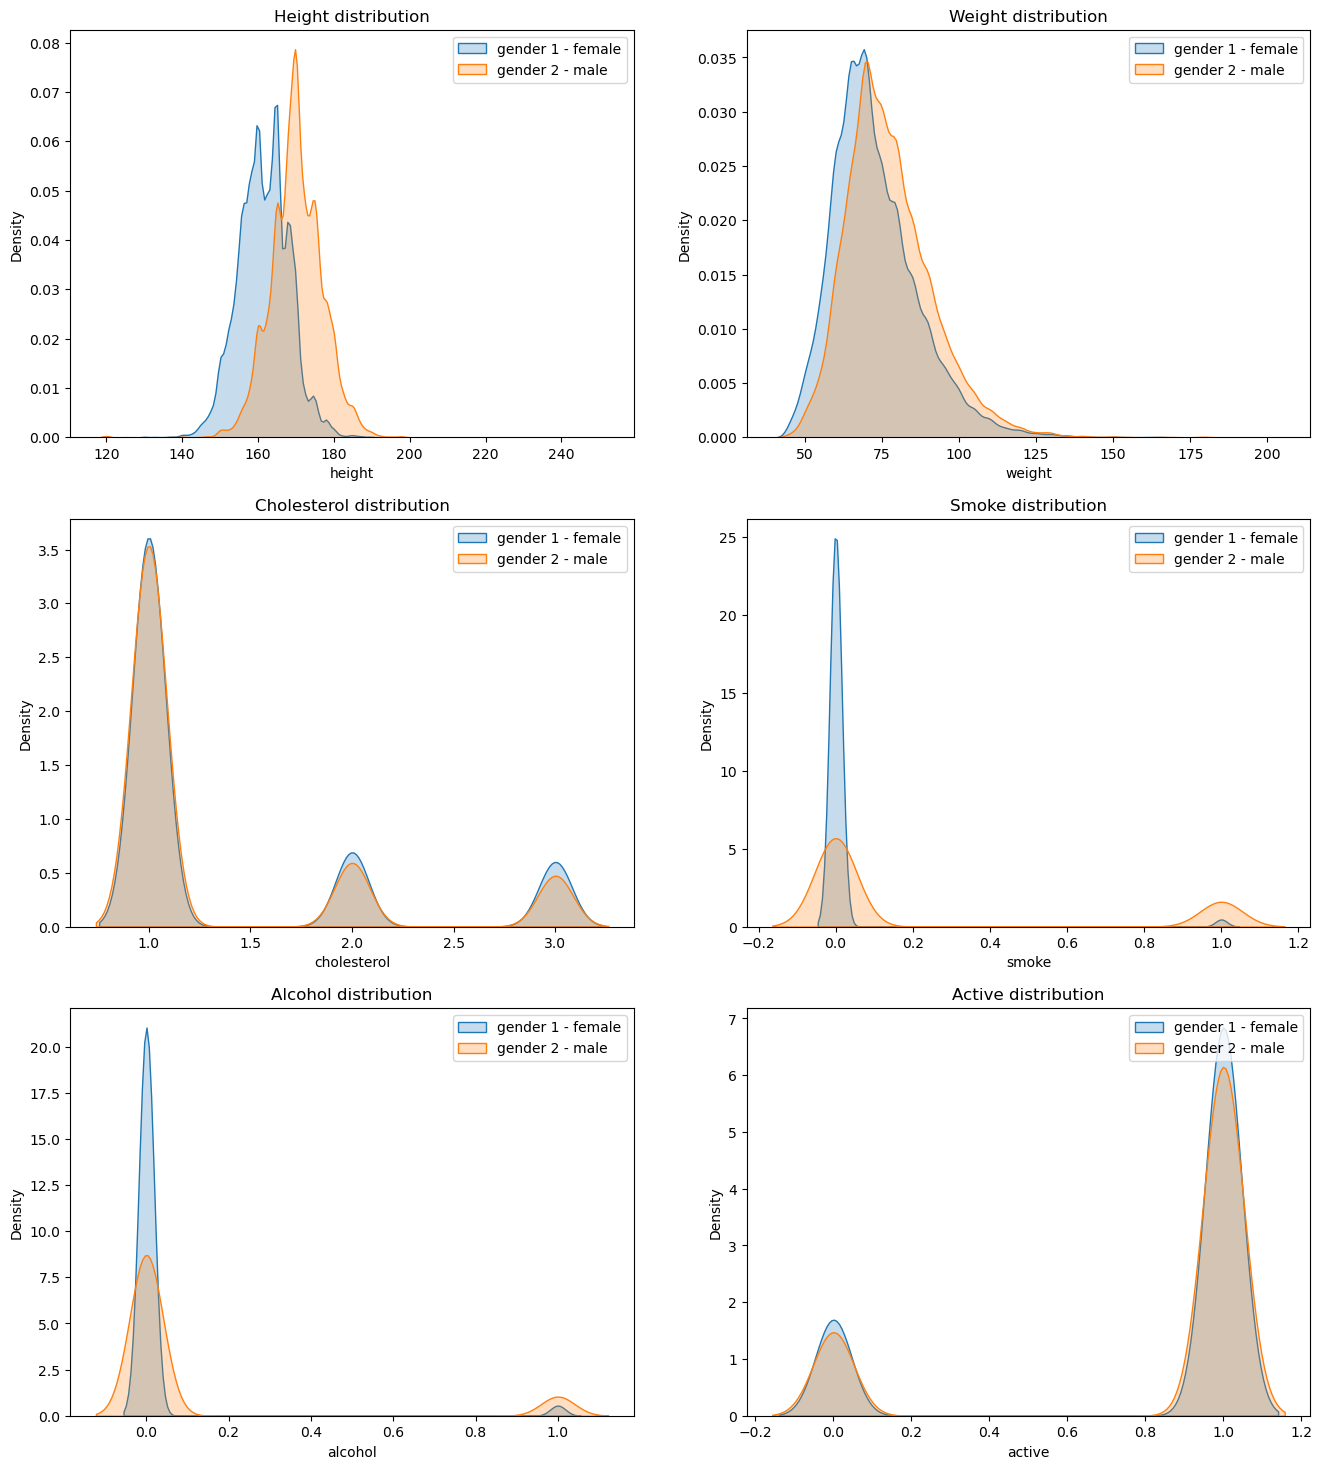

In [30]:
fig, axes = plt.subplots(3,2,figsize=(16,18))

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['height'], fill = True, label = 'gender 1 - female', 
            ax = axes[0,0], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['height'], fill = True, label = 'gender 2 - male', 
            ax = axes[0,0], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['weight'], fill = True, label = 'gender 1 - female', 
            ax = axes[0,1], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['weight'], fill = True, label = 'gender 2 - male', 
            ax = axes[0,1], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['cholesterol'], fill = True, label = 'gender 1 - female', 
            ax = axes[1,0], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['cholesterol'], fill = True, label = 'gender 2 - male', 
            ax = axes[1,0], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['smoke'], fill = True, label = 'gender 1 - female', 
            ax = axes[1,1], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['smoke'], fill = True, label = 'gender 2 - male', 
            ax = axes[1,1], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['alcohol'], fill = True, label = 'gender 1 - female', 
            ax = axes[2,0], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['alcohol'], fill = True, label = 'gender 2 - male', 
            ax = axes[2,0], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['active'], fill = True, label = 'gender 1 - female', 
            ax = axes[2,1], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['active'], fill = True, label = 'gender 2 - male', 
            ax = axes[2,1], legend = True);


axes[0,0].set_title('Height distribution')
axes[0,1].set_title('Weight distribution')
axes[1,0].set_title('Cholesterol distribution')
axes[1,1].set_title('Smoke distribution')
axes[2,0].set_title('Alcohol distribution')
axes[2,1].set_title('Active distribution')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[2,0].legend()
axes[2,1].legend()

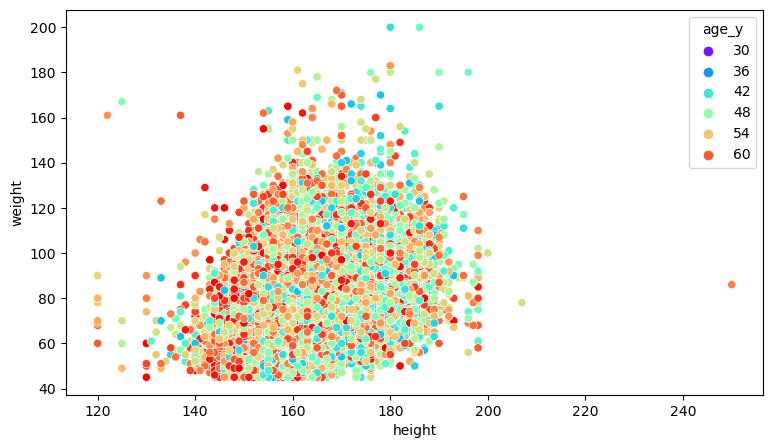

In [90]:
fig, axes = plt.subplots(1,1,figsize = (9,5))
sns.scatterplot(data = df4,x = 'height',y = 'weight', hue = 'age_y', palette = 'rainbow',ax = axes);

## Bivariate analysis

- H1 - we have more cardio disease in male individuals then female
- H2 - we have more cardio diseases in individuals with age higher than the average
- H3 - In proportion, individuals with cholesterol 2 have more cardio disease than 1
- H4 - In proportion, individuals with cholesterol 3 have more cardio disease than 2
- H5 - In proportion, individuals with alcohol 1 have more cardio disease than 0
- H6 - In proportion, individuals with smoke 1 have more cardio disease than 0
- H7 - In proportion, individuals with active 1 have less cardio disease than 0
- H8 - In proportion, individuals with glucose 2 have more cardio disease than 1
- H9 - In proportion, individuals with glucose 3 have more cardio disease than 2

### - H1 - we have more cardio disease in male individuals then female


In [31]:
aux1 = df4.groupby(['gender_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,gender_s,cardio,qtde_cardio
0,female,0,22691
1,female,1,22522
2,male,0,12083
3,male,1,12350


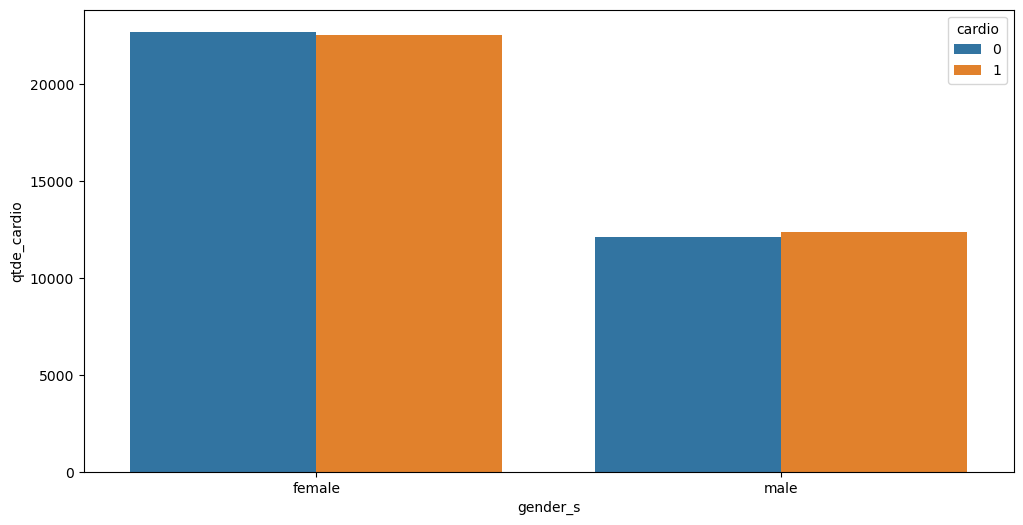

In [32]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'gender_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE - We have a proportion of female above than male, but male has more diseases than female

### - H2 - we have more cardio diseases in individuals with age higher than the average


In [33]:
avg_age = df4['age_y'].mean()
aux1 = df4.copy()
aux1['rel_avg_age'] = 'below average'
aux1.loc[aux1['age_y'] >= avg_age, 'rel_avg_age'] = 'above average'
aux1 = aux1.groupby(['rel_avg_age','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,rel_avg_age,cardio,qtde_cardio
0,above average,0,15886
1,above average,1,22662
2,below average,0,18888
3,below average,1,12210


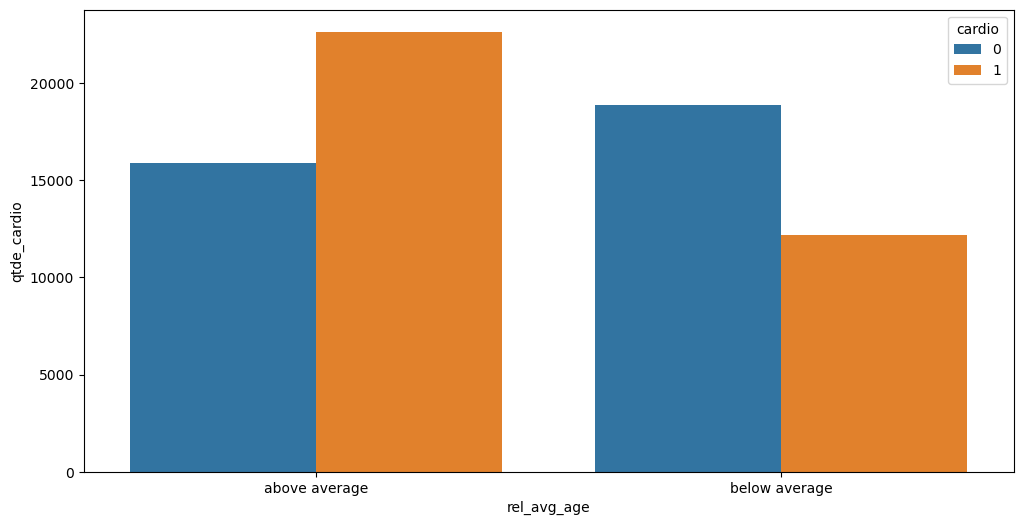

In [34]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'rel_avg_age',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE - individuals with age above the average has more chances of cardio disease

### - H3 - In proportion, individuals with cholesterol 2 have more cardio disease than 1


In [35]:
aux1 = df4.groupby(['cholesterol_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1 = aux1.loc[aux1['cholesterol_s'].isin(['normal','above normal'])]
aux1.head()

,cholesterol_s,cardio,qtde_cardio
0,above normal,0,3768
1,above normal,1,5734
2,normal,0,29120
3,normal,1,22981


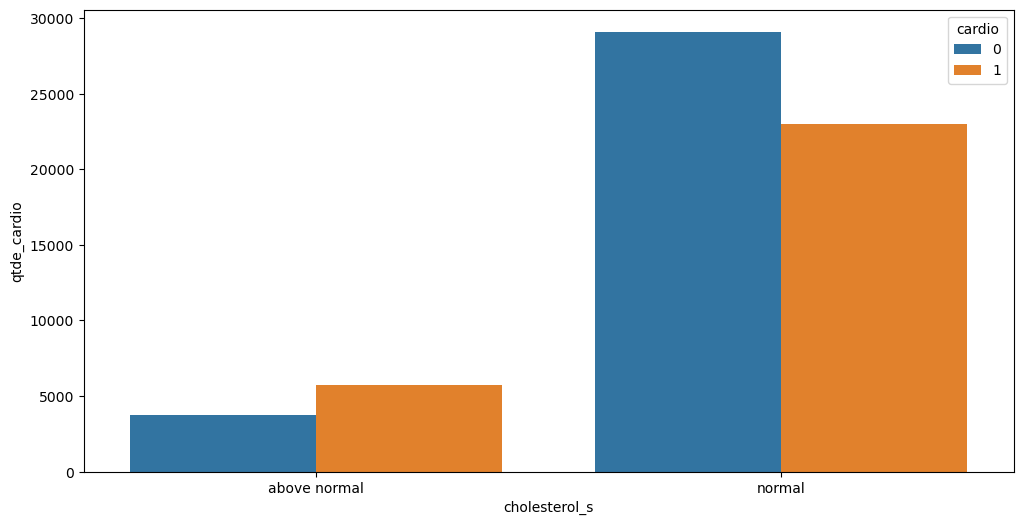

In [36]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'cholesterol_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE

### - H4 - In proportion, individuals with cholesterol 3 have more cardio disease than 2


In [37]:
aux1 = df4.groupby(['cholesterol_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1 = aux1.loc[aux1['cholesterol_s'].isin(['well above normal','above normal'])]
aux1.head()

,cholesterol_s,cardio,qtde_cardio
0,above normal,0,3768
1,above normal,1,5734
4,well above normal,0,1886
5,well above normal,1,6157


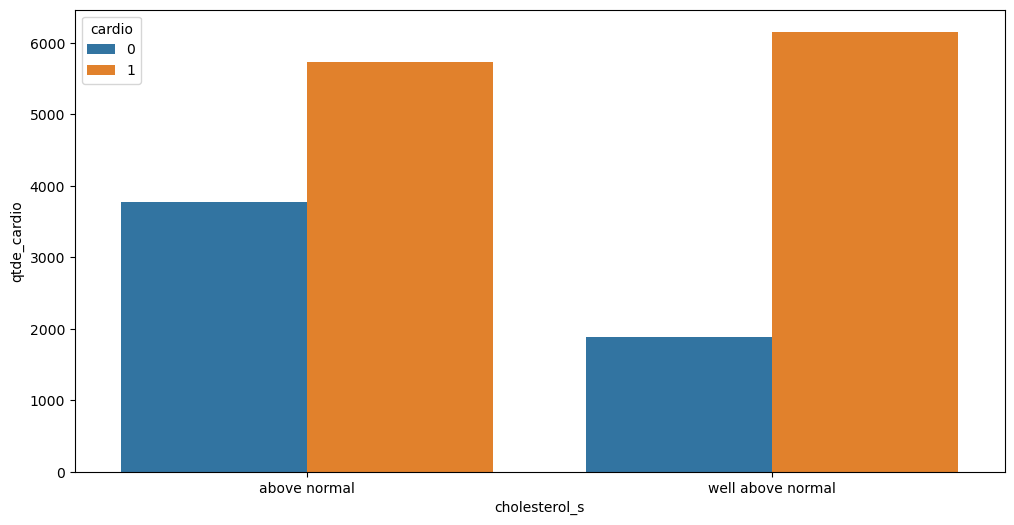

In [38]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'cholesterol_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE

### - H5 - In proportion, individuals with alcohol 1 have more cardio disease than 0


In [39]:
aux1 = df4.groupby(['alcohol_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,alcohol_s,cardio,qtde_cardio
0,alcoolic,0,1932
1,alcoolic,1,1821
2,non alcoolic,0,32842
3,non alcoolic,1,33051


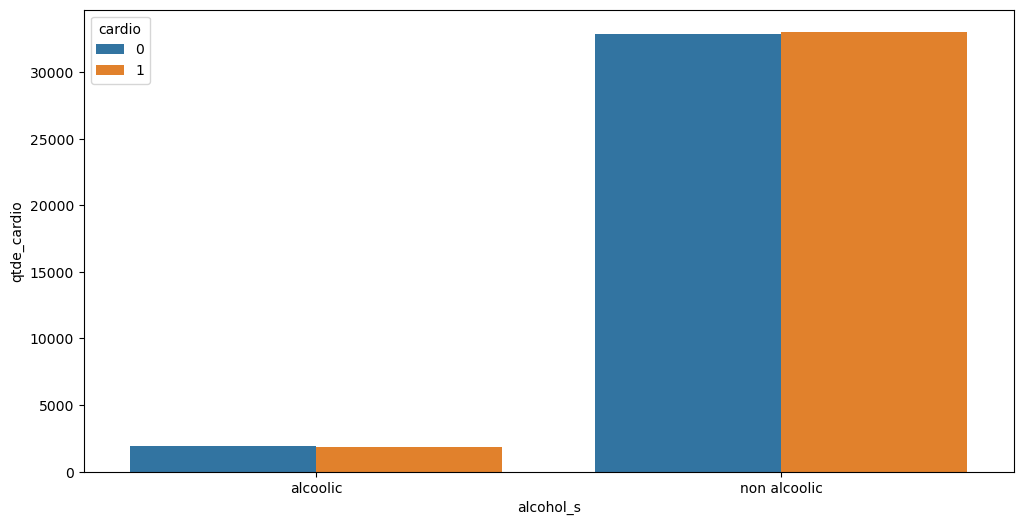

In [40]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'alcohol_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### FALSE - there's no difference

### - H6 - In proportion, individuals with smoke 1 have more cardio disease than 0


In [41]:
aux1 = df4.groupby(['smoke_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,smoke_s,cardio,qtde_cardio
0,non-smoking,0,31544
1,non-smoking,1,31948
2,smoking,0,3230
3,smoking,1,2924


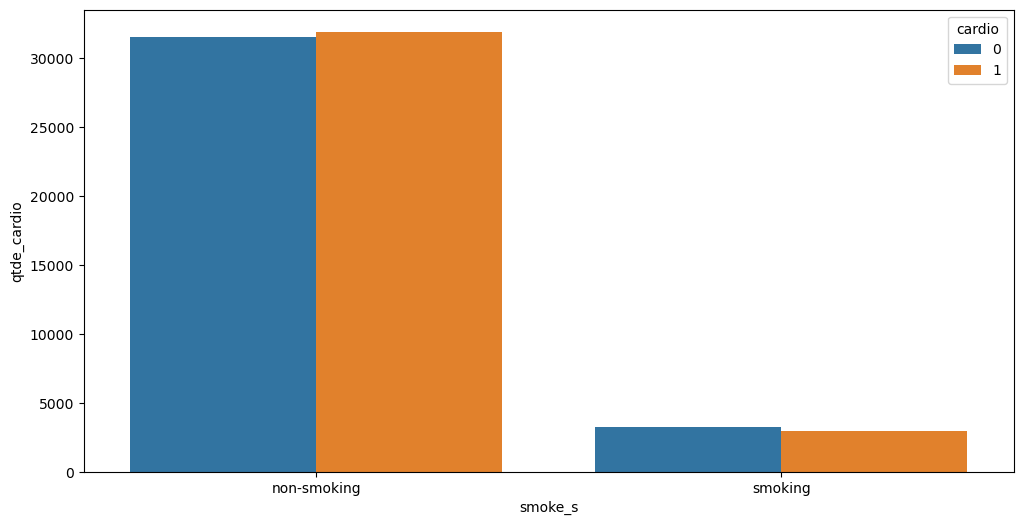

In [42]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'smoke_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### FALSE : no difference

### - H7 - In proportion, individuals with active 1 have less cardio disease than 0


In [43]:
aux1 = df4.groupby(['active_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,active_s,cardio,qtde_cardio
0,active,0,28435
1,active,1,27525
2,non active,0,6339
3,non active,1,7347


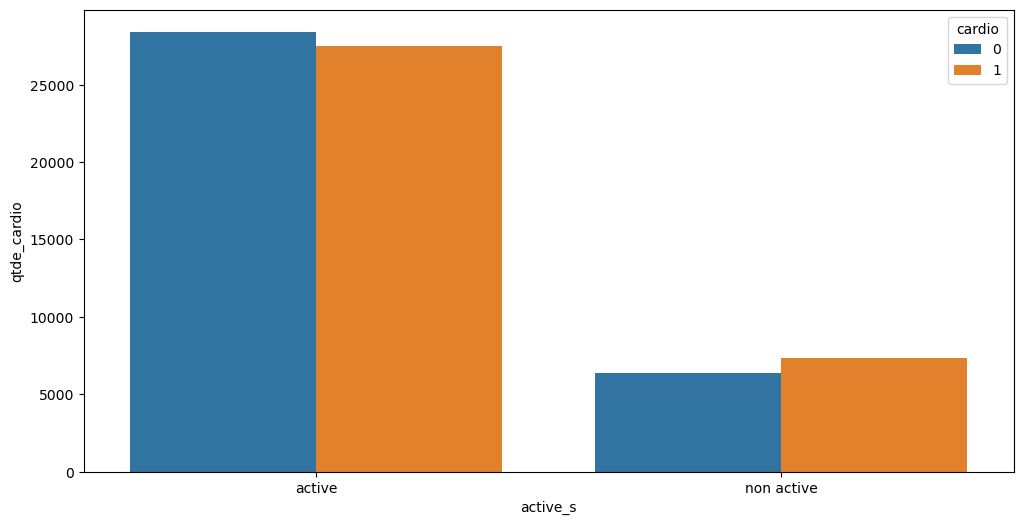

In [44]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'active_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE : non active has more chances

### - H8 - In proportion, individuals with glucose 2 have more cardio disease than 1


In [45]:
aux1 = df4.groupby(['gluc_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,gluc_s,cardio,qtde_cardio
0,above normal,0,2098
1,above normal,1,3074
2,normal,0,30669
3,normal,1,28491
4,well above normal,0,2007


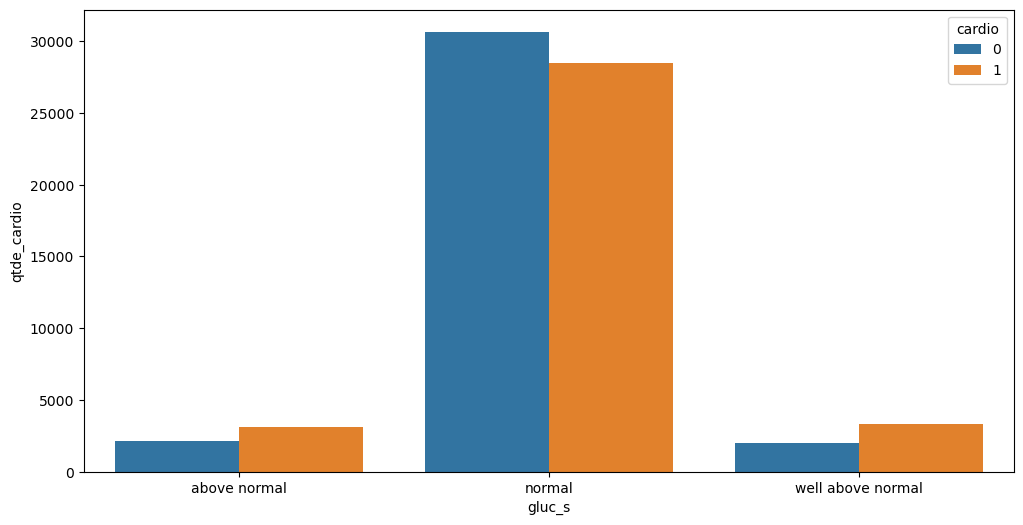

In [46]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'gluc_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE - increased levels of glucose can increase chances of cardio disease

### - H9 - In proportion, individuals with glucose 3 have more cardio disease than 2

## Multivariate analysis

C:\Users\pedro\AppData\Local\Temp\ipykernel_3064\1981286909.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df4.corr(method = 'pearson')


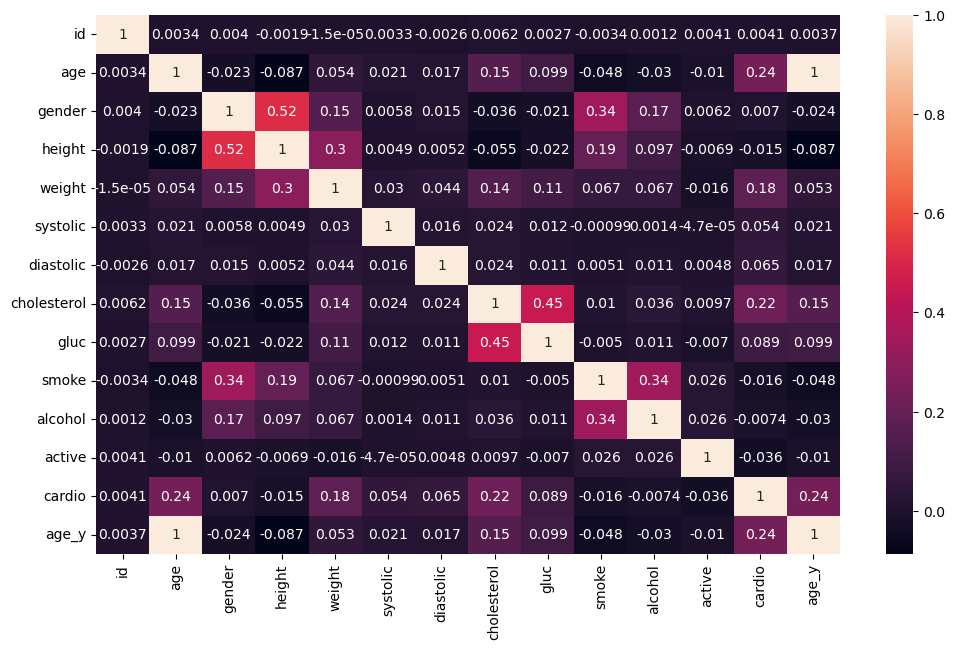

In [47]:
correlation = df4.corr(method = 'pearson')
fig, axes = plt.subplots(1,1,figsize=(12,7))
sns.heatmap(correlation, annot = True, ax = axes);

# Data Preparation

In [48]:
df5 = df4.copy()
print(df5.shape)
df5.head(3)

(69646, 20)


,id,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,cardio,age_y,gender_s,cholesterol_s,gluc_s,smoke_s,alcohol_s,active_s
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,male,normal,normal,non-smoking,non alcoolic,active
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,female,well above normal,normal,non-smoking,non alcoolic,active
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,female,well above normal,normal,non-smoking,non alcoolic,non active


## MinMax

In [49]:
for i in ['height','weight','systolic','diastolic','age_y']:
    min_max = MinMaxScaler()
    df5[i] = min_max.fit_transform(df5[[i]].values)
    joblib.dump(min_max, '../models/min_max_{}.pkl'.format(i))

df5.head()

,id,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,cardio,age_y,gender_s,cholesterol_s,gluc_s,smoke_s,alcohol_s,active_s
0,0,18393,2,0.369,0.110,0.016,0.014,1,1,0,0,1,0,0.600,male,normal,normal,non-smoking,non alcoolic,active
1,1,20228,1,0.277,0.258,0.018,0.014,3,1,0,0,1,1,0.743,female,well above normal,normal,non-smoking,non alcoolic,active
2,2,18857,1,0.346,0.123,0.017,0.013,3,1,0,0,0,1,0.629,female,well above normal,normal,non-smoking,non alcoolic,non active
3,3,17623,2,0.377,0.239,0.019,0.015,1,1,0,0,1,1,0.543,male,normal,normal,non-smoking,non alcoolic,active
4,4,17474,1,0.277,0.071,0.015,0.012,1,1,0,0,0,0,0.514,female,normal,normal,non-smoking,non alcoolic,non active


# Feature Selection

In [50]:
df6 = df5.copy()
df6.reset_index(drop = True, inplace = True)
df6.shape

(69646, 20)

In [51]:
cols_drop = ['age','id','gender_s','cholesterol_s','gluc_s','smoke_s','alcohol_s','active_s']

In [52]:
df6 = df6.drop(cols_drop, axis = 1)

## Split train/test

In [53]:
X = df6.drop(['cardio'], axis = 1)
y = df6[['cardio']]

In [54]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.2, random_state = 42)

In [55]:
print('x_train:',x_train.shape)
print('x_val:',x_val.shape)
print('x_test:',x_test.shape)

x_train: (44572, 11)
x_val: (11144, 11)
x_test: (13930, 11)


## Model

### RF

In [56]:
# model
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=10, max_depth=10,n_jobs = 2, random_state = 42)

# # fit
# rf.fit(x_train, y_train)

# # prediction
# y_hat_val = rf.predict(x_val)

# # performance
# rf_metrics = ml_metrics( 'random_forest', y_val, y_hat_val)
rf_metrics = model_cross_validation('random_forest', rf, X, y)

### LR

In [57]:
# model
lr_model = LogisticRegression(n_jobs = 2, random_state = 42)

# # fit
# lr_model.fit(x_train, y_train)

# # prediction
# y_hat_val = lr_model.predict(x_val)

# # performance
# lr_metrics = ml_metrics( 'logistic_regression', y_val, y_hat_val)
lr_metrics = model_cross_validation('logistic_regression', lr_model, X, y)

### XGB

In [58]:
# model
xgb_model = XGBClassifier(n_estimators=100, max_depth=10,n_jobs = 2, random_state = 42)

# # fit
# xgb_model.fit(x_train, y_train)

# # prediction
# y_hat_val = xgb_model.predict(x_val)

# # performance
# xgb_metrics = ml_metrics( 'xgb_classifier', y_val, y_hat_val)
xgb_metrics = model_cross_validation('xgb_classifier', xgb_model, X, y)

### KNN

In [59]:
# model
knn_model = KNeighborsClassifier(n_neighbors= 10,n_jobs = 2)

# # fit
# knn_model.fit(x_train, y_train)

# # prediction
# y_hat_val = knn_model.predict(x_val)

# # performance
# knn_metrics = ml_metrics( 'knn_classifier', y_val, y_hat_val)
knn_metrics = model_cross_validation('knn_classifier', knn_model, X, y)

### Comparison

In [60]:
modeling_result = pd.concat([rf_metrics, xgb_metrics, lr_metrics, knn_metrics])
modeling_result.sort_values('Mean ACC', ascending = False)

,Model Name,Mean ACC,Std ACC,Mean PRECISION,Std PRECISION,Mean RECALL,Std RECALL
0,random_forest,73.55,0.29,76.18,0.57,68.65,0.31
0,xgb_classifier,72.41,0.55,74.17,0.67,68.89,0.45
0,logistic_regression,64.79,0.58,65.78,0.73,61.87,0.30
0,knn_classifier,61.83,0.34,64.38,0.50,53.19,0.34


# Hyperparameter fine-tunning

In [61]:
param = {
    'n_estimators': [100, 300,500, 700, 900],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 9,13,17],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15,25]
    }
MAX_EVAL = 5

In [62]:
# rodar quando tiver tempo
xgb_metrics_tunning = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in  param.items() }
    print( hp )
    # model
    xgb_model_tunning = XGBClassifier(n_estimators=hp['n_estimators'], 
                        learning_rate = hp['learning_rate'], 
                        max_depth = hp['max_depth'], 
                        subsample = hp['subsample'], 
                        colsample_bytree = hp['colsample_bytree'],
                        min_child_weight = hp['min_child_weight'], 
                                      random_state = 42)

    # performance
    xgb_metrics = model_cross_validation('xgb_classifier', xgb_model_tunning, X, y)
    xgb_metrics_tunning = pd.concat([xgb_metrics_tunning, xgb_metrics])

xgb_metrics_tunning

{'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 17, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 700, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 25}
{'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 25}
{'n_estimators': 700, 'learning_rate': 0.01, 'max_depth': 17, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 900, 'learning_rate': 0.03, 'max_depth': 17, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}


,Model Name,Mean ACC,Std ACC,Mean PRECISION,Std PRECISION,Mean RECALL,Std RECALL
0,xgb_classifier,73.39,0.42,75.69,0.60,69.02,0.20
0,xgb_classifier,73.55,0.36,75.34,0.48,70.14,0.24
0,xgb_classifier,73.40,0.39,76.48,0.72,67.72,0.72
0,xgb_classifier,73.08,0.46,74.83,0.60,69.68,0.31
0,xgb_classifier,71.98,0.47,73.17,0.57,69.55,0.42


## Final model

In [63]:
final_param = {'n_estimators': 300, 'learning_rate': 0.05, 
 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}

In [64]:
# model
xgb_model_f = XGBClassifier(n_estimators=final_param['n_estimators'], 
                        learning_rate = final_param['learning_rate'], 
                        max_depth = final_param['max_depth'], 
                        subsample = final_param['subsample'], 
                        colsample_bytree = final_param['colsample_bytree'],
                        min_child_weight = final_param['min_child_weight'], 
                                      random_state = 42)

# fit
xgb_model_f.fit(x_train, y_train)

# prediction
y_hat_val = xgb_model_f.predict(x_val)

# performance
xgb_metrics = ml_metrics( 'xgb_classifier', y_val, y_hat_val)
# xgb_metrics = model_cross_validation('xgb_classifier', xgb_model, X, y)

In [65]:
xgb_metrics

,Model Name,ACC,PRECISION,RECALL
0,xgb_classifier,0.737,0.757,0.701


# Profit Estimation

In [77]:
df_estimation = pd.concat([x_test,y_test], axis = 1)

In [79]:
df_estimation.head()

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,age_y,cardio
56691,2,0.338,0.129,0.017,0.014,1,1,0,0,1,0.657,1
1696,1,0.292,0.090,0.017,0.014,1,1,0,0,0,1.000,1
58864,1,0.292,0.213,0.017,0.014,1,1,0,0,1,0.800,1
17735,2,0.362,0.187,0.018,0.015,3,1,0,0,1,0.743,1
58087,2,0.323,0.194,0.019,0.014,2,1,1,1,1,0.686,1


In [80]:
THRESHOLD = 0.5

In [82]:
df_estimation['predictions'] = xgb_model_f.predict_proba(x_test)[:,1]
df_estimation['percentage_above'] = df_estimation['predictions'].copy()
df_estimation.head()

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,age_y,cardio,predictions,percentage_above
56691,2,0.338,0.129,0.017,0.014,1,1,0,0,1,0.657,1,0.272,0.272
1696,1,0.292,0.090,0.017,0.014,1,1,0,0,0,1.000,1,0.609,0.609
58864,1,0.292,0.213,0.017,0.014,1,1,0,0,1,0.800,1,0.588,0.588
17735,2,0.362,0.187,0.018,0.015,3,1,0,0,1,0.743,1,0.834,0.834
58087,2,0.323,0.194,0.019,0.014,2,1,1,1,1,0.686,1,0.899,0.899


In [83]:
df_estimation.loc[df_estimation['percentage_above'] <= THRESHOLD,'percentage_above'] = 0

df_estimation.loc[(df_estimation['percentage_above'] > THRESHOLD) &
        (df_estimation['cardio'] == 0 ),'percentage_above'] = 0

df_estimation.loc[(df_estimation['percentage_above'] > THRESHOLD) &
        (df_estimation['cardio'] == 1 ),'percentage_above'] = np.floor(100*(df_estimation['percentage_above'] - 0.5)/5)
df_estimation.head()

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,age_y,cardio,predictions,percentage_above
56691,2,0.338,0.129,0.017,0.014,1,1,0,0,1,0.657,1,0.272,0.0
1696,1,0.292,0.090,0.017,0.014,1,1,0,0,0,1.000,1,0.609,2.0
58864,1,0.292,0.213,0.017,0.014,1,1,0,0,1,0.800,1,0.588,1.0
17735,2,0.362,0.187,0.018,0.015,3,1,0,0,1,0.743,1,0.834,6.0
58087,2,0.323,0.194,0.019,0.014,2,1,1,1,1,0.686,1,0.899,7.0


In [84]:
df_estimation['profit'] = df_estimation['percentage_above'] * 500

df_estimation.head()

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,age_y,cardio,predictions,percentage_above,profit
56691,2,0.338,0.129,0.017,0.014,1,1,0,0,1,0.657,1,0.272,0.0,0.0
1696,1,0.292,0.090,0.017,0.014,1,1,0,0,0,1.000,1,0.609,2.0,1000.0
58864,1,0.292,0.213,0.017,0.014,1,1,0,0,1,0.800,1,0.588,1.0,500.0
17735,2,0.362,0.187,0.018,0.015,3,1,0,0,1,0.743,1,0.834,6.0,3000.0
58087,2,0.323,0.194,0.019,0.014,2,1,1,1,1,0.686,1,0.899,7.0,3500.0


In [85]:
profit = round(df_estimation['profit'].sum(),2)

In [86]:
print('Possible porfit estimation: ${:,.2f}'.format(profit))

Possible porfit estimation: $12,363,500.00
